In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps, rcParams
import numpy as np
from numpy.polynomial import Polynomial
from scipy.interpolate import interp1d
from __future__ import annotations
c = 299792458 # speed of light in m/s

plt.style.use('seaborn-v0_8-whitegrid')
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "axes.titlecolor": "black",
    "grid.color": "lightgray",  # mantiene el grid visible pero tenue
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "text.color": "black",
})

In [63]:
"""df = pd.read_excel('Datos/XLSX/Aldebaran_pepsi.xlsx', sheet_name='Aldebaran_pepsi')
df.to_csv('Datos/CSV/Aldebaran_pepsi.csv', index=False)
iron = pd.read_excel('Datos/XLSX/Nave_table_2.xlsx', sheet_name='A', usecols="F")
iron.to_csv('Datos/CSV/Nave.csv', index=False)
arc_good = pd.read_excel('Datos/XLSX/Arcturus.xlsx', sheet_name='Good')
arc_possible = pd.read_excel('Datos/XLSX/Arcturus.xlsx', sheet_name='Possible')
arc_good.to_csv('Datos/CSV/Arcturus_good.csv', index=False)
arc_possible.to_csv('Datos/CSV/Arcturus_possible.csv', index=False)"""

'df = pd.read_excel(\'Datos/XLSX/Aldebaran_pepsi.xlsx\', sheet_name=\'Aldebaran_pepsi\')\ndf.to_csv(\'Datos/CSV/Aldebaran_pepsi.csv\', index=False)\niron = pd.read_excel(\'Datos/XLSX/Nave_table_2.xlsx\', sheet_name=\'A\', usecols="F")\niron.to_csv(\'Datos/CSV/Nave.csv\', index=False)\narc_good = pd.read_excel(\'Datos/XLSX/Arcturus.xlsx\', sheet_name=\'Good\')\narc_possible = pd.read_excel(\'Datos/XLSX/Arcturus.xlsx\', sheet_name=\'Possible\')\narc_good.to_csv(\'Datos/CSV/Arcturus_good.csv\', index=False)\narc_possible.to_csv(\'Datos/CSV/Arcturus_possible.csv\', index=False)'

In [64]:
iron = pd.read_csv("Datos/CSV/Nave.csv")
arc_good = pd.read_csv("Datos/CSV/Arcturus_good.csv")
arc_possible = pd.read_csv("Datos/CSV/Arcturus_possible.csv")

In [65]:
# Devuelve los índices i que cumplen con la condicion discreta de mínimo local: y[i-1] > y[i] < y[i+1]
def detect_discrete_minima_candidates(y: np.ndarray) -> np.ndarray:
    y = np.asarray(y)
    if y.size < 3:
        return np.array([], dtype=int)
    cond = (y[1:-1] < y[0:-2]) & (y[1:-1] < y[2:])
    return np.nonzero(cond)[0] + 1


# Ajusta un polinomio de grado 'degree' a los puntos (x_win, y_win) y refina la posición del mínimo local alrededor del punto x_center (candidato discreto). 
# Da información de la curvatura y si el mínimo es válido.
def _fit_poly_and_refine_min(x_win, y_win, degree, x_center):
    # Centrar x para mejorar la condición numérica
    x_shift = x_win - x_center
    coeffs = np.polyfit(x_shift, y_win, deg=degree)
    p = np.poly1d(coeffs)

    dp = p.deriv(1)
    d2p = p.deriv(2)
    d3p = p.deriv(3)

    # Raíces de la primera derivada (en el sistema centrado)
    roots = np.roots(dp)
    roots = roots[np.isclose(roots.imag, 0, atol=1e-12)].real

    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan, np.nan

    # Limitar raíces al rango de la ventana centrada
    x_min, x_max = x_shift.min(), x_shift.max()
    roots = roots[(roots >= x_min) & (roots <= x_max)]
    if len(roots) == 0:
        return np.nan, np.nan, False, False, np.nan, np.nan

    # Elegir la raíz más cercana al candidato (en coordenadas centradas)
    root_shift = roots[np.argmin(np.abs(roots - 0))]  # 0 porque centramos en x_center
    x_star = x_center + root_shift  # volver a coordenadas originales
    y_star = p(root_shift)

    second_deriv = d2p(root_shift)   # segunda derivada
    third_deriv = d3p(root_shift)  # tercera derivada
    is_min = second_deriv > 0

    return float(x_star), float(y_star), True, bool(is_min), float(second_deriv), float(third_deriv)



# Encuentra mínimos locales en los datos (x, y) ajustando polinomios en ventanas alrededor de los candidatos discretos.
def find_local_minima_polyfit(
    x: np.ndarray,
    y: np.ndarray,
    window_pts: int = 15,
    degree: int = 4,
    min_points: int = None,
    min_sd: float = 20,
    max_slope: float = 5e-7,
) -> pd.DataFrame:

    if window_pts < degree + 1:
        raise ValueError("window_pts debe ser al menos degree+1.")
    if min_points is None:
        min_points = degree + 1
    if min_points < degree + 1:
        raise ValueError("min_points debe ser >= degree+1.")

    n = len(x)
    half = window_pts // 2
    candidates = detect_discrete_minima_candidates(y)
    rows = []

    for i in candidates:
        start = max(0, i - half)
        end = min(n, start + window_pts)
        start = max(0, end - window_pts)

        x_win = x[start:end]
        y_win = y[start:end]

        if x_win.size < min_points:
            rows.append({
                "idx_candidate": int(i),
                "x_refined": np.nan,
                "y_refined": np.nan,
                "second_deriv": np.nan,
                "curvature": np.nan,
                "third_deriv": np.nan,
                "slope": np.nan,
                "valid_minimum": False,
            })
            continue

        try:
            x_star, y_star, root_in_window, is_min, second_deriv, third_deriv = _fit_poly_and_refine_min(
                x_win, y_win, degree, x_center=x[i]
            )
        except np.linalg.LinAlgError:
            x_star, y_star, root_in_window, is_min, second_deriv, third_deriv = np.nan, np.nan, False, False, np.nan

        # Calcular curvatura y pendiente de la bisectriz
        
        curvature = second_deriv * x_star**2
        #curvature = second_deriv

        
        #slope = (-c*third_deriv)/(3*x_star*(second_deriv**2))

        slope = (-x_star*third_deriv)/(3*c*(second_deriv**2))

        #depth = (np.median(y_win) - y_star) / np.median(y_win)

        x_win = np.asarray(x_win)
        y_win = np.asarray(y_win)
        
        extremos_altos = (y_win[0] > y_star + 0.5 * (np.max(y_win) - np.min(y_win))) and (y_win[-1] > y_star + 0.5 * (np.max(y_win) - np.min(y_win)))


        valid = bool(is_min and 
                     curvature >= min_sd * x_star**2 and
                     abs(slope) <= max_slope and
                     extremos_altos)

        rows.append({
            "idx_candidate": int(i),
            "x_refined": x_star,
            "y_refined": y_star,
            "second_deriv": second_deriv,  
            "curvature": curvature,
            "third_deriv": third_deriv,
            "slope": slope,
            "valid_minimum": valid
        })

    return pd.DataFrame(rows)



In [66]:
df = pd.read_csv('Datos/CSV/Aldebaran_pepsi.csv')


x = df.iloc[:,0]  # primera columna
y = df.iloc[:,1]  # segunda columna


df_min = find_local_minima_polyfit(x, y, window_pts=15, degree=4)
df_min = df_min[df_min["valid_minimum"]]

#GRAFICA ESPECTRO COMPLETO
"""fig, ax = plt.subplots(figsize=(9, 4))

# Curva principal
ax.plot(x, y, color='#003f5c', linewidth=1.3, label=r'\textbf{Espectro PEPSI}')


# Etiquetas y título
ax.set_xlabel(r'\textbf{Longitud de onda} [\AA]')
ax.set_ylabel(r'\textbf{Intensidad normalizada}')
ax.set_title(r'\textbf{Espectro de Aldebarán}')

# Cuadrícula y leyenda
ax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)
ax.legend(frameon=False, loc='best')

# Bordes más limpios
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# No se usa tight_layout() para mantener márgenes originales
plt.tight_layout()

plt.show()"""

<>:19: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
<>:19: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
C:\Users\larag\AppData\Local\Temp\ipykernel_24272\1451976412.py:19: SyntaxWarning: "\A" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\A"? A raw string is also an option.
  ax.set_xlabel(r'\textbf{Longitud de onda} [\AA]')


"fig, ax = plt.subplots(figsize=(9, 4))\n\n# Curva principal\nax.plot(x, y, color='#003f5c', linewidth=1.3, label=r'\textbf{Espectro PEPSI}')\n\n\n# Etiquetas y título\nax.set_xlabel(r'\textbf{Longitud de onda} [\\AA]')\nax.set_ylabel(r'\textbf{Intensidad normalizada}')\nax.set_title(r'\textbf{Espectro de Aldebarán}')\n\n# Cuadrícula y leyenda\nax.grid(True, linestyle='--', linewidth=0.6, alpha=0.7)\nax.legend(frameon=False, loc='best')\n\n# Bordes más limpios\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False)\n\n# No se usa tight_layout() para mantener márgenes originales\nplt.tight_layout()\n\nplt.show()"


Pendientes calculadas en df_min_range:
  - Mínimo en x = 3955.33561 Å → pendiente = -0.000000
  - Mínimo en x = 3955.78988 Å → pendiente = -0.000000
  - Mínimo en x = 3955.95639 Å → pendiente = 0.000000


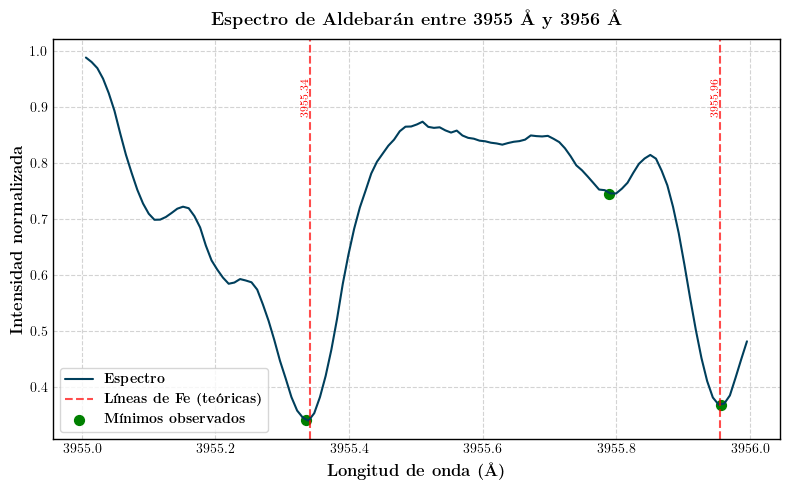

In [67]:
# === COPIA INDEPENDIENTE ===
x_copy = x.copy()
y_copy = y.copy()
df_min_copy = df_min.copy()

# Rango de interés
#x1 = 3955.7
#x2 = 3955.87

x1 = 3955
x2 = 3956

mask = (x_copy >= x1) & (x_copy <= x2)
x_range = x_copy[mask]
y_range = y_copy[mask]
window_pts = 15

# Líneas teóricas
iron_lines = pd.read_csv("Datos/CSV/Nave.csv", header=None)[0]
iron_in_range = iron_lines[(iron_lines >= x1) & (iron_lines <= x2)]

# Mínimos observados
df_min_range = df_min_copy[(df_min_copy["x_refined"] >= x1) & (df_min_copy["x_refined"] <= x2)]

# === GRAFICAR ESPECTRO BASE ===
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_range, y_range, label=r"\textbf{Espectro}", color="#003f5c", linewidth=1.5)

# Líneas teóricas
for i, wl in enumerate(iron_in_range):
    ax.axvline(wl, color="red", linestyle="--", alpha=0.7,
               label=r"\textbf{Líneas de Fe (teóricas)}" if i == 0 else "")
    ax.text(wl, max(y_range)*0.96, f"{wl:.2f}", rotation=90,
            verticalalignment="top", horizontalalignment="right",
            fontsize=8, color="red")

# Mínimos observados
ax.scatter(df_min_range["x_refined"], df_min_range["y_refined"],
           color="green", marker="o", s=50, label=r"\textbf{Mínimos observados}")

"""# === AJUSTE POLINÓMICO PARA CONSTRUIR LA BISECTRIZ ===
row = df_min_range.iloc[0]
idx = int(row["idx_candidate"])
half = window_pts // 2
start = max(0, idx - half)
end = min(len(x_copy), start + window_pts)
start = max(0, end - window_pts)

x_win = x_copy[start:end]
y_win = y_copy[start:end]
x_shift = x_win - x_copy[idx]

coeffs = np.polyfit(x_shift, y_win, deg=4)
p = np.poly1d(coeffs)

x_dense = np.linspace(x_win.min(), x_win.max(), 400)
y_dense = p(x_dense - x_copy[idx])
ax.plot(x_dense, y_dense, "--", color="purple", linewidth=1.3, label=r"\textbf{Ajuste polinómico}")

# === BISECTRIZ REAL (FORMA DE C) DESDE EL POLINOMIO ===
y_min = np.min(y_dense)
y_max = np.max(y_dense)
y_levels = np.linspace(y_min, y_max, 80)

x_bis_list, y_bis_list = [], []

for y0 in y_levels:
    coeff_shifted = coeffs.copy()
    coeff_shifted[-1] -= y0
    roots = np.roots(coeff_shifted)
    roots_real = np.real(roots[np.isreal(roots)])
    roots_real = roots_real[(roots_real >= x_dense.min() - x_copy[idx]) &
                            (roots_real <= x_dense.max() - x_copy[idx])]
    if len(roots_real) >= 2:
        x_left = np.min(roots_real) + x_copy[idx]
        x_right = np.max(roots_real) + x_copy[idx]
        x_mid = (x_left + x_right) / 2
        x_bis_list.append(x_mid)
        y_bis_list.append(y0)

x_bis = np.array(x_bis_list)
y_bis = np.array(y_bis_list)

ax.plot(x_bis, y_bis, color="magenta", linewidth=2.2, label=r"\textbf{Bisectriz}")

# === PENDIENTE DEL DF_MIN_RANGE (TU CÁLCULO) ===
dx_vis = 0.02
scale = 0.001

for i, row in df_min_range.iterrows():
    x0, y0, slope = row["x_refined"], row["y_refined"], row["slope"]
    x_vals = [x0 - dx_vis, x0 + dx_vis]
    y_vals = [y0 - slope * dx_vis * scale, y0 + slope * dx_vis * scale]
    ax.plot(x_vals, y_vals, color="orange", linewidth=2.5,
            label=r"\textbf{Pendiente en mínimo}" if i == df_min_range.index[0] else "")"""
    
print("\nPendientes calculadas en df_min_range:")
for i, row in df_min_range.iterrows():
    print(f"  - Mínimo en x = {row['x_refined']:.5f} Å → pendiente = {row['slope']:.6f}")

# === DETALLES ESTÉTICOS ===
ax.set_xlabel(r"\textbf{Longitud de onda (Å)}", fontsize=12)
ax.set_ylabel(r"\textbf{Intensidad normalizada}", fontsize=12)
ax.set_title(rf"\textbf{{Espectro de Aldebarán entre {x1} Å y {x2} Å}}", fontsize=13, pad=10)
ax.legend(frameon=True, fancybox=True, shadow=False, fontsize=10)
ax.grid(True, linestyle="--", alpha=1)

plt.tight_layout()
plt.show()

In [68]:
tol = 0.1
matches = []

for theo in iron.iloc[:, 0]:
    nearby = df_min[(df_min["x_refined"].notna()) & 
                    (abs(df_min["x_refined"] - theo) <= tol)]
    if not nearby.empty:
        # Seleccionar el match con menor diferencia
        obs = nearby.iloc[(nearby["x_refined"] - theo).abs().argmin()]
        matches.append({
            "lambda_theo": theo,
            "lambda_obs": obs["x_refined"],
            "y_obs": obs["y_refined"],
            "delta": obs["x_refined"] - theo,
            "curvature": obs["curvature"],
            "slope": obs["slope"]
        })

df_matches = pd.DataFrame(matches) 
df_matches = df_matches.drop_duplicates(subset=["lambda_obs"], keep="first")
df_matches["velocity_ms"] = c * (df_matches["delta"]) / df_matches["lambda_theo"]
print(df_matches)

     lambda_theo   lambda_obs     y_obs     delta     curvature         slope  \
0      3951.1632  3951.156905  0.299289 -0.006295  2.181841e+09 -2.875623e-07   
1      3953.1514  3953.154887  0.316196  0.003487  3.149937e+09  8.204449e-08   
2      3955.3413  3955.335611  0.341159 -0.005689  2.835581e+09 -1.646694e-07   
3      3955.9555  3955.956386  0.368267  0.000886  3.147971e+09  1.718642e-07   
4      3957.0184  3957.046204  0.155937  0.027804  1.888271e+09 -1.466954e-07   
..           ...          ...       ...       ...           ...           ...   
725    9078.5716  9078.542669  0.338399 -0.028931  6.432067e+09  1.730792e-07   
726    9088.3186  9088.323131  0.338658  0.004531  3.280001e+09  2.503806e-07   
727    9103.6375  9103.626160  0.728207 -0.011340  2.786734e+09  1.819168e-07   
728    9117.1327  9117.140957  0.066899  0.008257  5.926000e+09 -8.972858e-08   
729    9118.8816  9118.883521  0.351210  0.001921  3.027061e+09  1.524750e-07   

     velocity_ms  
0    -47

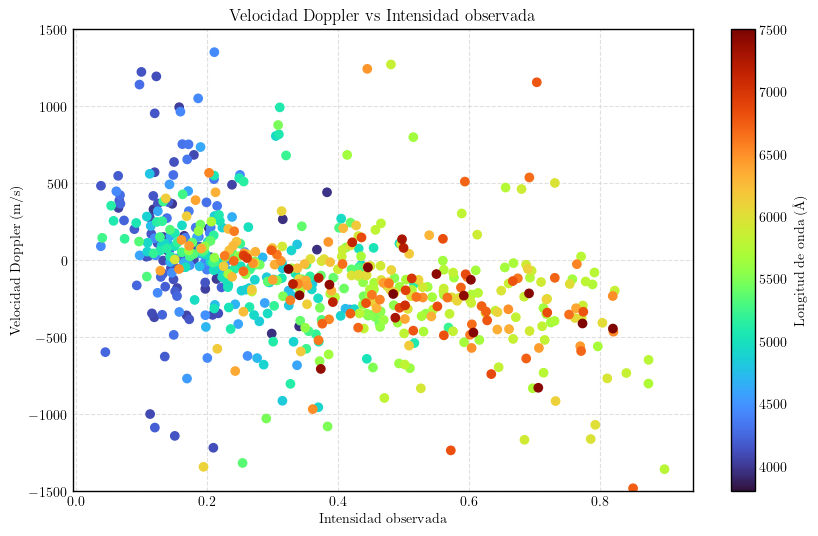

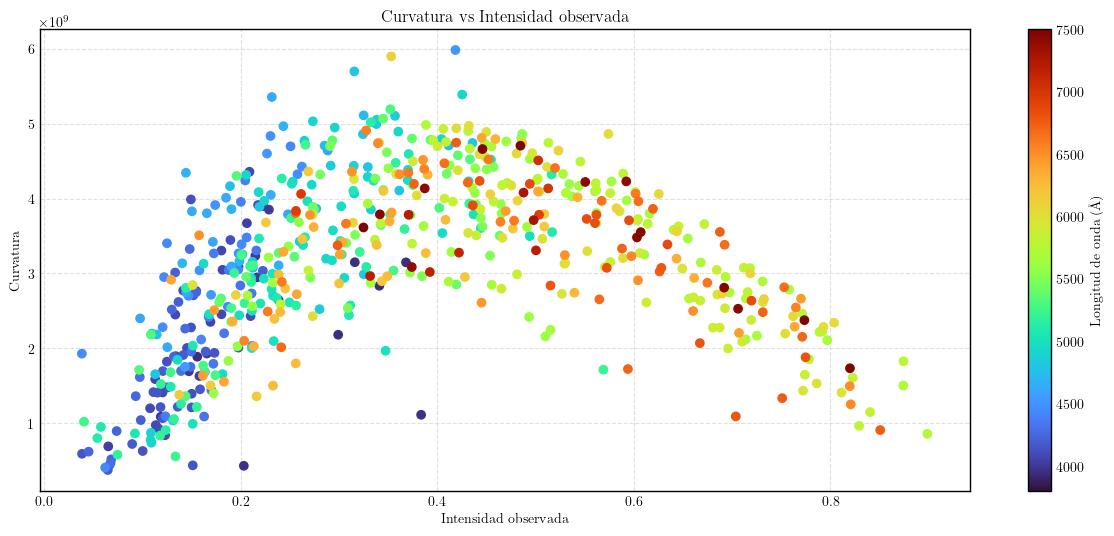

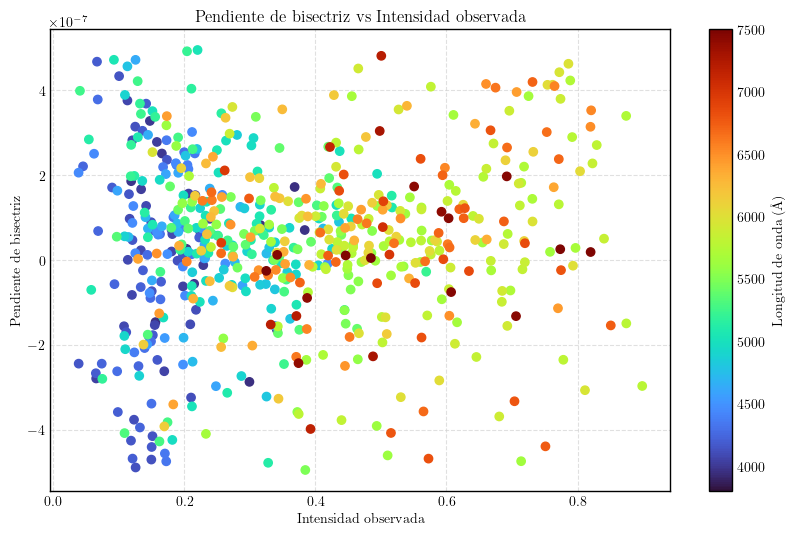

In [69]:
# Manejo de versiones de matplotlib para colormaps
try:
    cmap = colormaps["turbo"]
except (ImportError, AttributeError):
    import matplotlib.cm as cm
    cmap = cm.get_cmap("turbo")

# Definir rango visible de longitudes de onda (en Ångström)
wl_min, wl_max = 3800, 7500
norm = mcolors.Normalize(vmin=wl_min, vmax=wl_max)

# Crear columna de colores
df_matches["Color"] = df_matches["lambda_obs"].apply(lambda wl: cmap(norm(wl)))

# Filtrar el rango visible
df_visible = df_matches[(df_matches["lambda_obs"] >= wl_min) & (df_matches["lambda_obs"] <= wl_max)]

# Gráfico 1: Velocidad Doppler vs Intensidad observada
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_visible["y_obs"],
    df_visible["velocity_ms"],
    c=df_visible["lambda_obs"],
    cmap=cmap,
    norm=norm
)
plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (m/s)")
plt.ylim(-1500, 1500)
plt.title("Velocidad Doppler vs Intensidad observada")
plt.grid(True, linestyle="--", alpha=0.7)
plt.colorbar(sc, label="Longitud de onda (Å)")
plt.show()

# Gráfico 2: Curvatura vs Intensidad observada
plt.figure(figsize=(15, 6))
sc = plt.scatter(
    df_visible["y_obs"],
    df_visible["curvature"],
    c=df_visible["lambda_obs"],
    cmap=cmap,
    norm=norm
)
plt.ylabel("Curvatura")
plt.xlabel("Intensidad observada")
plt.title("Curvatura vs Intensidad observada")
plt.grid(True, linestyle="--", alpha=0.7)
plt.colorbar(sc, label="Longitud de onda (Å)")
plt.show()

# Gráfico 3: Pendiente vs Intensidad observada
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    df_visible["y_obs"],
    df_visible["slope"],
    c=df_visible["lambda_obs"],
    cmap=cmap,
    norm=norm
)
plt.xlabel("Intensidad observada")
plt.ylabel("Pendiente de bisectriz")
plt.title("Pendiente de bisectriz vs Intensidad observada")
plt.grid(True, linestyle="--", alpha=0.7)
plt.colorbar(sc, label="Longitud de onda (Å)")
plt.show()


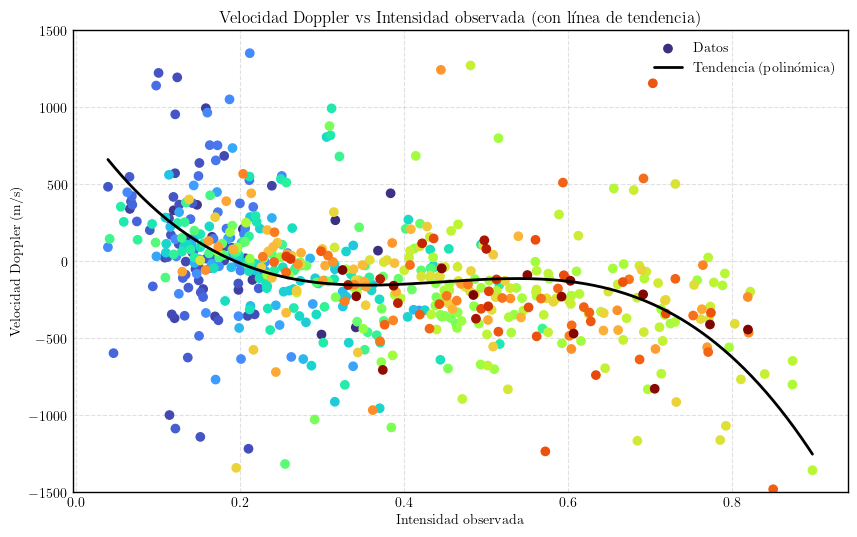

In [70]:
import numpy as np

# Ajuste polinómico (ejemplo: grado 3, puedes variar)
x = df_visible["y_obs"].values
y = df_visible["velocity_ms"].values

# Ordenar por x para trazar bien la curva
order = np.argsort(x)
x_sorted = x[order]
y_sorted = y[order]

# Ajuste polinomial
coeffs = np.polyfit(x_sorted, y_sorted, deg=3)
poly = np.poly1d(coeffs)

# Curva ajustada
x_fit = np.linspace(x_sorted.min(), x_sorted.max(), 500)
y_fit = poly(x_fit)

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=df_visible["Color"], label="Datos")
plt.plot(x_fit, y_fit, "k-", linewidth=2, label="Tendencia (polinómica)")
plt.xlabel("Intensidad observada")
plt.ylabel("Velocidad Doppler (m/s)")
plt.ylim(-1500, 1500)
plt.title("Velocidad Doppler vs Intensidad observada (con línea de tendencia)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.show()